In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
plt.rcParams['figure.dpi'] = 150
import seaborn as sns
from Bio import SeqIO, Seq

import glob, os, yaml, subprocess, itertools, sparse, sys
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
# from statsmodels.distributions.empirical_distribution import ECDF
import sklearn.metrics
from sklearn.decomposition import PCA
import timeit
import scipy.stats as st
import pickle, yaml, tracemalloc
from scipy.stats import binomtest

drugs_loci = pd.read_csv("../data/drugs_loci.csv")
eigenvec_df = pd.read_csv("../data/eigenvec_10PC.csv").set_index("sample_id")
pca_explained_var = np.load("../data/pca_explained_var.npy")
who_variants_combined = pd.read_csv("../analysis/who_confidence_2021.csv")

sample_ids_mapping = pd.read_csv("../data/sample_ids_mapping.csv")
samples_summary = pd.read_csv("../data/samples_summary.csv")
drug_CC = pd.read_csv("../data/drug_CC.csv")
analysis_dir = '/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue'
input_data_dir = '/n/data1/hms/dbmi/farhat/ye12/who'
who_variants_combined = pd.read_csv("../analysis/who_confidence_2021.csv")

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "analysis"))
from stats_utils import *

lineages = pd.read_csv("../data/lineages.csv", low_memory=False)
keep_lineages = lineages.merge(eigenvec_df, left_on="Sample_ID", right_index=True)

In [2]:
samples_summary.sort_values("Genos", ascending=False)

,Drug,Genos,Binary_Phenos,SNP_Matrix,MICs,Lineages,Tier1_LOF,Tier1_Inframe,Tier2_LOF,Tier2_Inframe
7,Isoniazid,48706,48706,48706,12827,48076,291,36,15432.0,102.0
14,Rifampicin,47730,47730,47730,12876,47044,0,181,1122.0,116.0
5,Ethambutol,45515,45515,45515,12916,44827,1,49,1195.0,111.0
9,Levofloxacin,27576,27576,27576,11447,26909,1,25,700.0,49.0
15,Streptomycin,26166,26166,26166,1486,25793,10474,64,381.0,29.0
0,Amikacin,24710,24710,24710,12641,24024,426,24,431.0,9.0
8,Kanamycin,24582,24582,24582,12753,23916,400,42,483.0,11.0
11,Moxifloxacin,22783,22783,22783,12753,22116,0,14,623.0,39.0
13,Pyrazinamide,21319,21319,21319,1146,20938,638,70,5432.0,88.0
6,Ethionamide,20936,20936,20936,12690,20626,2270,146,675.0,30.0


In [3]:
drugs_loci

,Gene Name,Drugs,Start,End,New?,Notes
0,gyrBA,"LEVO, MOXI, OFX, CIP, GATI",4997,9818,N,NaN
1,eis,"KAN, AMI",2713783,2716314,N,NaN
2,pncA,PZA,2287883,2289599,N,NaN
3,panD,PZA,4043041,4045210,Y,NaN
4,oxyR-ahpC,INH,2725477,2726780,N,NaN
5,rrs-rrl,"AMI, KAN, STR, CAP",1471576,1477013,N,NaN
6,tlyA,CAP,1917755,1918746,N,NaN
7,rpsA,PZA,1833378,1834987,N,NaN
8,acpM-kasA,INH,2517695,2519365,N,NaN
9,embCAB,EMB,4239663,4249810,Y,Changed start to be 200 bp upstream of embC


# Make Pie Chart of Lineages

## Manually add other stuff to the pie chart, like lineage name and percentage on the chart itself

In [4]:
lineage_summary = pd.DataFrame(keep_lineages["Primary_Lineage"].value_counts())

other_cols = ["5", "6", "7", "BOV_AFRI", "BOV", "canetti"]
lineage_summary.loc["5,6,7,Other", ["Primary_Lineage"]] = [lineage_summary.loc[other_cols].Primary_Lineage.sum()]

lineage_summary = lineage_summary.reset_index().rename(columns={"index":"Lineage", "Primary_Lineage": "Count"})
lineage_summary = lineage_summary.sort_values("Lineage", ascending=True)
lineage_summary = lineage_summary.query("Lineage not in @other_cols")

lineage_summary["Count"] = lineage_summary["Count"].astype(int)

In [5]:
lineage_summary.Count.sum()

51228

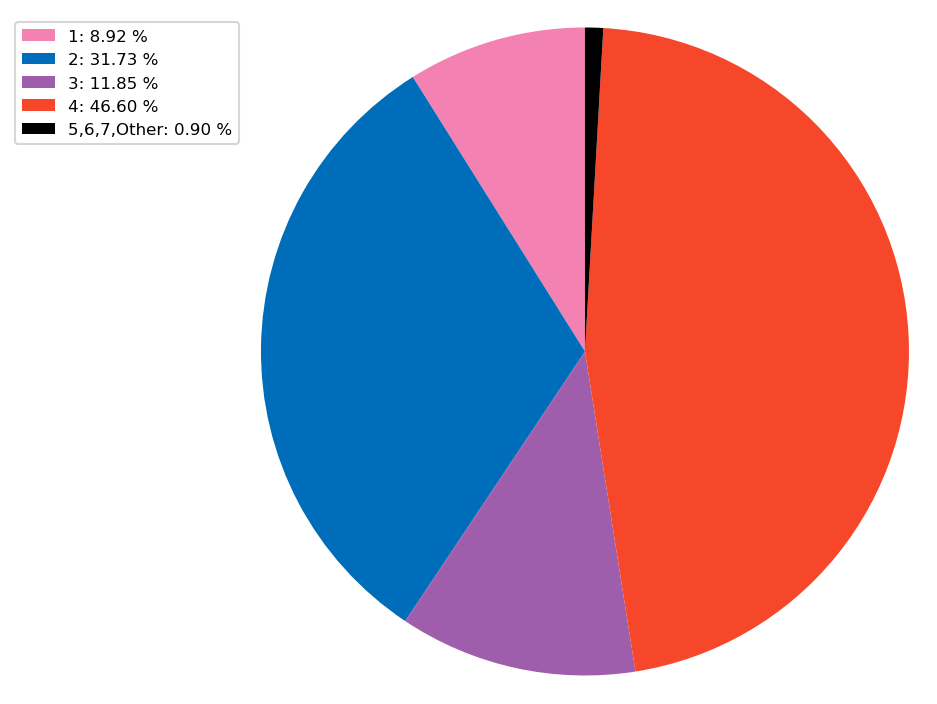

In [6]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = lineage_summary["Lineage"]
sizes = lineage_summary["Count"]
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig, ax = plt.subplots()
# ax.pie(sizes, #explode=explode, 
#        labels=labels, autopct='%1.0f%%', startangle=90)
# ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

LinToColor_Dict = {"1": "#f381b2",
                   "2": "#006dbb",
                   "3": "#9f5eab",
                   "4": "#f6472b",
                   # "5": "#76400e",
                   # "6": "#36ba74",
                   # "7": "#ffb000",
                   "5,6,7,Other": "black",
                  }

colors = [LinToColor_Dict[lineage] for lineage in lineage_summary["Lineage"].values]

wedge_sizes = 100.*sizes/sizes.sum()
patches, texts = plt.pie(sizes, colors=colors, startangle=90, radius=1.2)
labels = ['{0}: {1:1.2f} %'.format(i,j) for i,j in zip(labels, wedge_sizes)]

sort_legend = False
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, sizes),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.tight_layout()
plt.legend(patches, labels, bbox_to_anchor=(0, 1.), fontsize=8)
plt.savefig("Figures/lineage_pie.png", dpi=300)

# Exploded Pie Chart for Sublineages of L2 and L4 (Focus on L2.2.1 later on)

https://matplotlib.org/stable/gallery/pie_and_polar_charts/bar_of_pie.html

In [7]:
L2_summary = pd.DataFrame(keep_lineages.query("Primary_Lineage=='2'")["Lineage_1"].value_counts())

other_cols = ["2", "2.1", "2.2"]
L2_summary.loc["2,2.1,2.2", ["Lineage_1"]] = [L2_summary.loc[other_cols].Lineage_1.sum()]
L2_summary.loc["2.2.1", ["Lineage_1"]] = [L2_summary.loc[["2.2.1", "2.2.1.1", "2.2.1.2"]].Lineage_1.sum()]

L2_summary = L2_summary.reset_index().rename(columns={"index": "Lineage", "Lineage_1": "Count"}).query("Lineage not in @other_cols")
L2_summary = L2_summary.query("Lineage not in ['2.2.1.1', '2.2.1.2']")

L2_summary = L2_summary.sort_values("Lineage", ascending=True)
L2_summary

,Lineage,Count
7,"2,2.1,2.2",145.0
0,2.2.1,15303.0
2,2.2.2,805.0


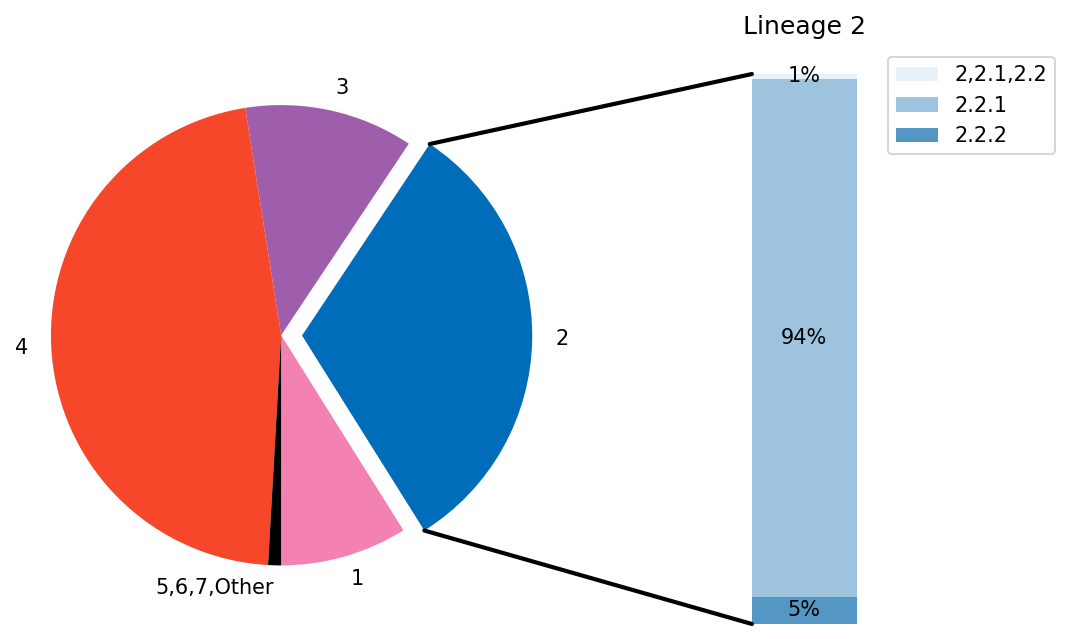

In [10]:
wedge_idx = 1

# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters
overall_ratios = wedge_sizes.values
labels = lineage_summary["Lineage"]
explode = np.zeros(len(labels))
explode[wedge_idx] = 0.1

# rotate so that first wedge is split by the x-axis
angle = -180 * overall_ratios[wedge_idx]
wedges, *_ = ax1.pie(overall_ratios, colors=colors, startangle=270, radius=1.1,
                     labels=labels, explode=explode)

# bar chart parameters
age_ratios = L2_summary["Count"].values/L2_summary["Count"].sum() #[.33, .54, .07, .06]
age_labels = L2_summary["Lineage"].values
bottom = 1
width = .2

# Adding from the top matches the legend.
for j, (height, label) in enumerate([*zip(age_ratios, age_labels)]):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label,
                 alpha=0.1 + (1/len(age_ratios)) * j
                )
    ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

ax2.set_title('Lineage 2')
ax2.legend()
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[wedge_idx].theta1, wedges[wedge_idx].theta2
center, r = wedges[wedge_idx].center, wedges[wedge_idx].r
bar_height = sum(age_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(2)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(2)

plt.savefig("Figures/L2_breakdown.png", dpi=300)

# Distribution of Resistance Across Drugs

In [11]:
df_resistance = pd.DataFrame(columns=["Drug", "Resistant", "Susceptible"])

for i, drug in enumerate(os.listdir(analysis_dir)):
    
    df_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv"))
    df_resistance.loc[i, :] = [drug, len(df_phenos.query("phenotype==1")), len(df_phenos.query("phenotype==0"))]
    
df_resistance["Total"] = df_resistance["Resistant"] + df_resistance["Susceptible"]
df_resistance = df_resistance.sort_values("Total", ascending=False)

df_resistance["R_prop"] = df_resistance["Resistant"] / df_resistance["Total"]
df_resistance["S_prop"] = df_resistance["Susceptible"] / df_resistance["Total"]

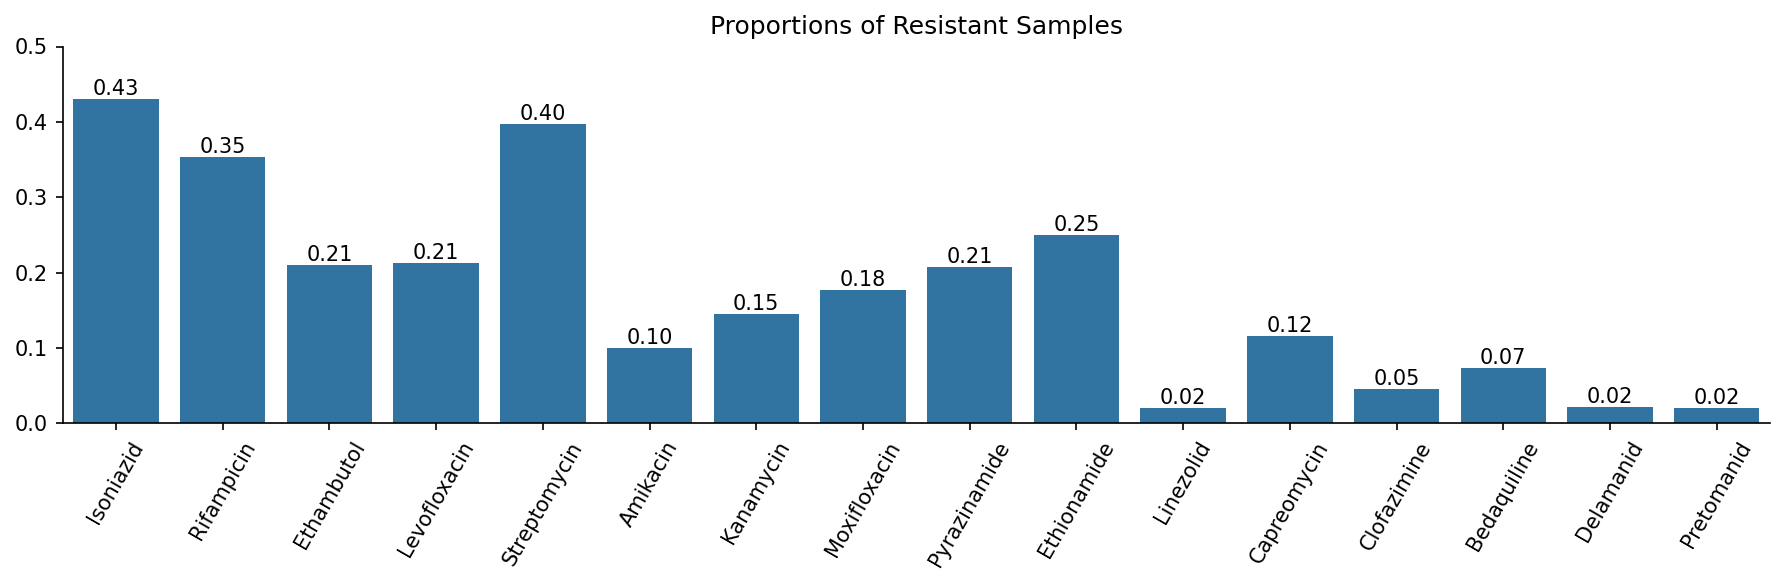

In [12]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(data=df_resistance, x="Drug", y="R_prop", color='#1f77b4', ax=ax)
ax.bar_label(ax.containers[0], fmt='%.2f')

plt.xticks(rotation=60)
plt.xlabel("")
plt.ylabel("")
plt.title("Proportions of Resistant Samples")
sns.despine()
plt.ylim(0, 0.5)
plt.tight_layout()
plt.savefig("Figures/resistance_summary.png", dpi=300)

In [13]:
#df_resistance.set_index('Drug')[["R_prop", "S_prop"]].plot(kind='bar', stacked=True, color=['steelblue', 'red'])

# MDR- and XDR-TB Metrics

2021 Updates to pre-XDR and XDR definitions: https://www.who.int/news/item/27-01-2021-who-announces-updated-definitions-of-extensively-drug-resistant-tuberculosis

<ul>
    <li>MDR: RIF and INH</li>
    <li>pre-XDR: MDR + any fluoroquinolone</li>
    <li>XDR: MDR + any fluoroquinolone + Group A drug (levofloxacin, moxifloxacin, bedaquiline and linezolid)</li>
</ul>


Group A drugs are the most potent group of drugs in the ranking of second-line medicines for the treatment of drug-resistant forms of TB using longer treatment regimens.

In [14]:
combined_phenos = pd.DataFrame(columns=["Drug", "sample_id", "phenotype"])

for drug in os.listdir(analysis_dir):
    
    df_phenos = pd.read_csv(os.path.join(analysis_dir, drug, "phenos_binary.csv"))
    df_phenos["Drug"] = drug
    combined_phenos = pd.concat([combined_phenos, df_phenos[["Drug", "sample_id", "phenotype"]]], axis=0)
    
combined_phenos = combined_phenos.pivot(index="sample_id", columns="Drug", values="phenotype")
print(f"{len(combined_phenos)} samples passed QC")

52567 samples passed QC


/home/sak0914/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [15]:
MDR = combined_phenos.query("Rifampicin==1 & Isoniazid==1").index.values
len(MDR)

15709

In [16]:
total = len(combined_phenos.loc[(~pd.isnull(combined_phenos["Rifampicin"])) & (~pd.isnull(combined_phenos["Isoniazid"]))])

In [17]:
RIF_R = len(combined_phenos.loc[(~pd.isnull(combined_phenos["Rifampicin"])) & (combined_phenos["Rifampicin"]==1)])
RIF_R / total

0.35893560404470465

In [18]:
INH_R = len(combined_phenos.loc[(~pd.isnull(combined_phenos["Isoniazid"])) & (combined_phenos["Isoniazid"]==1)])
INH_R / total

0.4460031931878659

In [19]:
pre_XDR = combined_phenos.query("Rifampicin==1 & Isoniazid==1 & (Levofloxacin==1 | Moxifloxacin==1)").index.values
len(pre_XDR)

5261

In [20]:
combined_phenos.loc[(~pd.isnull(combined_phenos["Rifampicin"])) & 
                    (~pd.isnull(combined_phenos["Isoniazid"])) &
                    (~pd.isnull(combined_phenos["Levofloxacin"])) & 
                    (~pd.isnull(combined_phenos["Moxifloxacin"]))
                   ].shape

(18737, 16)

In [21]:
combined_phenos.loc[(~pd.isnull(combined_phenos["Rifampicin"])) & 
                    (~pd.isnull(combined_phenos["Isoniazid"])) &
                    (~pd.isnull(combined_phenos["Levofloxacin"])) & 
                    (~pd.isnull(combined_phenos["Moxifloxacin"])) &
                    (~pd.isnull(combined_phenos["Bedaquiline"])) & 
                    (~pd.isnull(combined_phenos["Linezolid"]))
                   ].shape

(11907, 16)

In [22]:
# for XDR, there are 2 minimum cases: 1) MDR + BOTH fluoroquinolones, 2) MDR + 1 fluoroquinolone + 1 of BDQ and LZD
XDR = set(combined_phenos.query("Rifampicin==1 & Isoniazid==1 & Levofloxacin==1 & Moxifloxacin==1").index).union(combined_phenos.query("Rifampicin==1 & Isoniazid==1 & (Levofloxacin==1 | Moxifloxacin==1) & (Bedaquiline==1 | Linezolid==1)"))
len(XDR)


2911

# Lineage Analysis

Color Picker: https://imagecolorpicker.com/en

Copy-pasted this image in: https://www.nature.com/articles/nrmicro.2018.8/figures/1

In [40]:
np.sum(pca_explained_var)

0.9945456708799382

In [42]:
pca_explained_var[:5]

array([0.58689256, 0.20490904, 0.12659903, 0.0397996 , 0.01650627])

In [41]:
np.sum(pca_explained_var[:5])

0.9747064921271958

In [45]:
np.sum([58.7,
20.5,
12.7,
3.98,
1.65,])

97.53000000000002

In [24]:
combined_phenos_PCA = combined_phenos.merge(eigenvec_df, left_index=True, right_index=True).merge(lineages.set_index("Sample_ID")[["Primary_Lineage", "Lineage_1", "Lineage_2"]],
                                                                                                  left_index=True, right_on="Sample_ID", how="inner"
                                                                                                 )

In [25]:
combined_phenos_PCA.groupby("Primary_Lineage")[os.listdir(analysis_dir)].mean().T.reset_index().sort_values("index", ascending=True).round(2).iloc[:, :7]

Primary_Lineage,index,1,2,3,4,5,6
3,Amikacin,0.02,0.15,0.04,0.08,0.00,0.00
9,Bedaquiline,0.02,0.02,0.14,0.01,0.00,0.00
10,Capreomycin,0.01,0.14,0.03,0.12,0.00,0.00
5,Clofazimine,0.02,0.06,0.07,0.03,0.00,0.00
13,Delamanid,0.02,0.02,0.05,0.01,0.00,0.00
4,Ethambutol,0.08,0.35,0.09,0.17,0.22,0.01
15,Ethionamide,0.23,0.32,0.11,0.23,0.00,0.00
14,Isoniazid,0.23,0.63,0.27,0.37,0.38,0.09
8,Kanamycin,0.02,0.22,0.05,0.12,0.00,0.00
0,Levofloxacin,0.07,0.31,0.20,0.13,0.00,0.00


In [ ]:
# LinToColor_Dict = {"1": "#DF83AC",
#                    "2": "#7098CB",
#                    "3": "#815D9F",
#                    "4": "#E76956",
#                    "5": "#B67548",
#                    "6": "#6AB79E",
#                    "7": "#E4515B",
#                   }
LinToColor_Dict = {"1": "#f381b2",
                   "2": "#006dbb",
                   "3": "#9f5eab",
                   "4": "#f6472b",
                   "5": "#76400e",
                   "6": "#36ba74",
                   "7": "#ffb000",
                  }

sns.scatterplot(data=combined_phenos_PCA.query("Primary_Lineage in ['1', '2', '3', '4', '5', '6', '7']"), 
                x="PC0", y="PC1", 
                hue="Primary_Lineage",
                hue_order=['1', '2', '3', '4', '5', '6', '7'],
                palette=LinToColor_Dict,
                alpha=0.7,
                )

plt.tight_layout()
plt.legend(loc="upper right", fontsize=10)
sns.despine()
plt.savefig("Figures/PC0_PC1.png", dpi=300)

# Predictive Models

In [8]:
drug = "Moxifloxacin"
tiers_lst = ["1"]
summary_1 = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/prediction_models/tiers={'+'.join(tiers_lst)}_bootstrap_binary_stats.csv"))


In [37]:
lower, upper = np.percentile(summary_1.iloc[1:, :], axis=0, q=[2.5, 97.5])
lower, upper

(array([0.92298921, 0.882134  , 0.93173333, 0.92405619, 0.90919471]),
 array([0.92688513, 0.88833747, 0.9376    , 0.92778753, 0.91096873]))

In [34]:
drug = "Moxifloxacin"
tiers_lst = ["1", "2"]
summary_12 = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/prediction_models/tiers={'+'.join(tiers_lst)}_bootstrap_binary_stats.csv"))
lower, upper = np.percentile(summary_12.iloc[1:, :], axis=0, q=[2.5, 97.5])


In [35]:
lower, upper

(array([0.9269167 , 0.88337469, 0.92531342, 0.92030735, 0.91011914]),
 array([0.93380284, 0.89826303, 0.93865031, 0.92908891, 0.91228132]))

In [50]:
_, pvals = st.ttest_ind(summary_1.iloc[1:], summary_12.iloc[1:], axis=0, equal_var=False, 
                        alternative="two-sided")

In [51]:
pvals

array([0.00000000e+00, 1.82820249e-90, 1.00767150e-06, 6.03279599e-01,
       0.00000000e+00])